# Part 3: Support Vector Machine

### In this section, the cleaned text will be vectorized using TF-IDF (covered in Part 2) and will be used to train a Support Vector Machine (SVM). Specifically, the model used is the sklearn LinearSVC for classification problems.

### This section will also explore and test different methods of fine-tuning the SVM and evaluating its effectiveness

In [26]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sb
import spacy
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

adasyn=ADASYN()
sb.set()

""" NOTE: SET YOUR PROJECT ROOT DIRECTORY HERE """
PROJ_DIR = r""
RANDOM_SPLIT_SEED = 11

In [8]:
!{sys.executable} -m pip install pandas_profiling
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install imblearn
!{sys.executable} -m spacy download en_core_web_md

     ---------------------------------------- 42.8/42.8 MB 7.3 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [13]:
### SECTION COPIED FROM PART 2, PLEASE REFER TO DESCRIPTION FOUND THERE

df = pd.read_csv(PROJ_DIR + r"\sc1015-project\dataset\fake_job_postings.csv")

cleaned_text = pd.read_csv('lemmatized_text.csv').squeeze() # convert to pd series
cleaned_text.head()
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vectorizer.fit(cleaned_text)
tfidf_data = vectorizer.transform(cleaned_text)
sss=StratifiedShuffleSplit(n_splits=1, random_state=RANDOM_SPLIT_SEED, test_size=0.2)
X=np.zeros(shape=tfidf_data.shape[0],dtype=np.bool_)
y=np.array(df['fraudulent']) #prediction target
for train_index, test_index in sss.split(X, y):
    X_train, X_test = tfidf_data[train_index,:], tfidf_data[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
X_res, y_res = adasyn.fit_resample(X_train, y_train)

Here, we use feature selection for dimensionality reduction. Specifically, the default selector will remove all zero variance features.

In [18]:
selector = SelectFromModel(estimator=LinearSVC()).fit(X_res, y_res)
print(selector)
X_select = selector.transform(X_res)
X_select_test = selector.transform(X_test)

SelectFromModel(estimator=LinearSVC())


The SVC will be fitted here and the accuracy score will test the prediction against the labeled output data

In [22]:
svc = LinearSVC().fit(X_select, y_res)
train_pred = svc.predict(X_select)
test_pred = svc.predict(X_select_test)
print(f"SVC train accuracy score: {accuracy_score(train_pred,y_res)}")
print(f"SVC test accuracy score : {accuracy_score(test_pred,y_test)}")


SVC train accuracy score: 0.9998529303625266
SVC test accuracy score : 0.9876957494407159


It can be observed that the classification accuracy is very high for both train and test datasets.

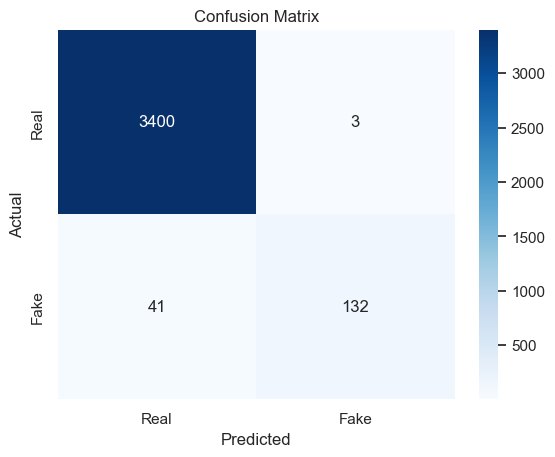

True Positive Rate: 0.7630057803468208
True Negative Rate: 0.9991184249191889
False Positive Rate: 0.000881575080811049
False Negative Rate: 0.23699421965317918
Accuracy: 0.9876957494407159


In [30]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, test_pred)

# Define the class labels
class_names = ['Real', 'Fake']

# Create a heatmap of the confusion matrix
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Set the axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

TPR = TP / (TP + FN)
print("True Positive Rate:", TPR)
TNR = TN / (TN + FP) 
print("True Negative Rate:", TNR)
FPR = FP / (FP + TN)
print("False Positive Rate:", FPR)
FNR = FN / (TP + FN)
print("False Negative Rate:", FNR)
ACC = (TP + TN) / (TP + FP + FN + TN)
print("Accuracy:", ACC)

Shown above is the confusion matrix for the TEST set. It can be observed that all stats are very good, except for the true positive rate (i.e is fraudulent) which is 0.76. One of the reasons could be that there exist much fewer examples of fraudulent in the dataset.